In [ ]:
!pip install kagglehub --quiet

In [ ]:
!pip install scikit-image --quiet

In [ ]:
import kagglehub

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog, local_binary_pattern

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
path = kagglehub.dataset_download("omkarmanohardalvi/lungs-disease-dataset-4-types")
print("Dataset downloaded to:", path)


100%|██████████| 2.02G/2.02G [00:28<00:00, 75.8MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1


In [ ]:
for root, dirs, files in os.walk(path):
    print(root, "->", len(files), "files")


/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1 -> 0 files
/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset -> 0 files
/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset/train -> 0 files
/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset/train/Corona Virus Disease -> 1218 files
/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset/train/Bacterial Pneumonia -> 1205 files
/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset/train/Tuberculosis -> 1220 files
/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset/train/Normal -> 1207 files
/root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-d

In [ ]:
IMG_SIZE = 128

def extract_hog(img):
    # img must be 2D grayscale
    features = hog(
        img,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return features

def extract_lbp(img):
    radius = 2
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')

    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, n_points + 3),
        range=(0, n_points + 2)
    )

    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist


In [ ]:
import os
import cv2
import numpy as np

X = []
y = []

print("Scanning dataset structure...\n")
print("Root path from kagglehub:", path)
print("Top-level contents:", os.listdir(path))

# ---- 4.1: Find the folder that actually contains train/test/val ----

def find_data_root(base_path):
    target_names = {"train", "test", "val"}
    for root, dirs, files in os.walk(base_path):
        lower_dirs = {d.lower() for d in dirs}
        if target_names.issubset(lower_dirs):
            print("✅ Found train/test/val here:", root)
            return root
    print("⚠️ train/test/val not found explicitly, using base_path as data root")
    return base_path

data_root = find_data_root(path)
print("Using data_root:", data_root)
print("Contents of data_root:", os.listdir(data_root))

# ---- 4.2: Helper – check if file looks like an image ----

valid_exts = {".png", ".jpg", ".jpeg", ".bmp"}

def is_image_file(fname):
    return os.path.splitext(fname)[1].lower() in valid_exts

# ---- 4.3: Loop over splits and classes, extract HOG + LBP ----

print("\nLoading images and extracting features...\n")

for split in os.listdir(data_root):
    split_path = os.path.join(data_root, split)
    if not os.path.isdir(split_path):
        continue

    print(f"Split: {split}")

    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"  Class: {class_name}")

        for fname in os.listdir(class_path):
            if not is_image_file(fname):
                continue

            fpath = os.path.join(class_path, fname)

            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                # skip broken/unreadable image
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            try:
                hog_feat = extract_hog(img)
                lbp_feat = extract_lbp(img)
            except Exception as e:
                # if *one* image breaks HOG/LBP, skip it and continue
                print("    Skipping file due to error:", fpath, "->", e)
                continue

            features = np.hstack([hog_feat, lbp_feat])

            X.append(features)
            y.append(class_name)

X = np.array(X)
y = np.array(y)

print("\n✅ Done feature extraction")
print("Total samples:", X.shape[0])
print("Feature dim:", X.shape[1])
print("Classes:", np.unique(y))


Scanning dataset structure...

Root path from kagglehub: /root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1
Top-level contents: ['Lung Disease Dataset']
✅ Found train/test/val here: /root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset
Using data_root: /root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset
Contents of data_root: ['train', 'test', 'val']

Loading images and extracting features...

Split: train
  Class: Corona Virus Disease
  Class: Bacterial Pneumonia
  Class: Tuberculosis
  Class: Normal
  Class: Viral Pneumonia
Split: test
  Class: Corona Virus Disease
  Class: Bacterial Pneumonia
  Class: Tuberculosis
  Class: Normal
  Class: Viral Pneumonia
Split: val
  Class: Corona Virus Disease
  Class: Bacterial Pneumonia
  Class: Tuberculosis
  Class: Normal
  Class: Viral Pneumonia

✅ Done feature extraction
Total samples: 1

In [ ]:
import os

def get_sample_image_path(data_root):
    for split in os.listdir(data_root):
        split_path = os.path.join(data_root, split)
        if not os.path.isdir(split_path):
            continue

        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue

            for fname in os.listdir(class_path):
                if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                    return os.path.join(class_path, fname)

    return None

sample_img_path = get_sample_image_path(data_root)
print("Sample image selected:", sample_img_path)


Sample image selected: /root/.cache/kagglehub/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types/versions/1/Lung Disease Dataset/train/Corona Virus Disease/00030636_012.png


HOG feature length:      1764
LBP histogram length:    18
Combined feature length: 1782


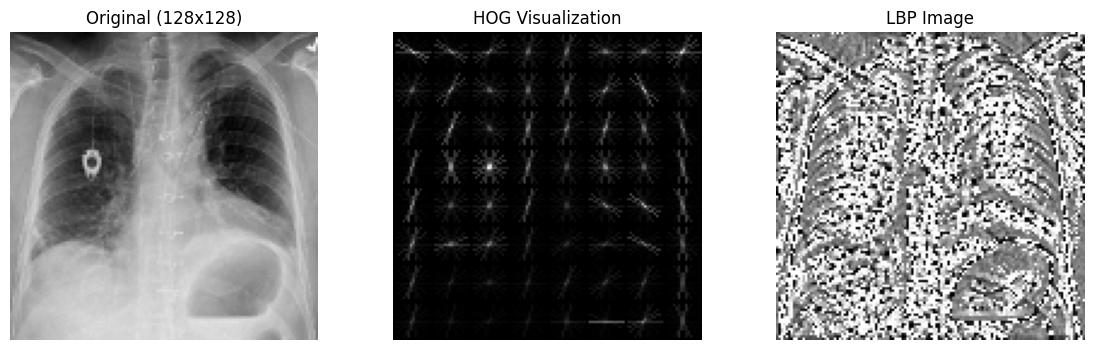

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load and preprocess image
# ------------------------------
IMG_SIZE = 128
img_path = sample_img_path


# Read as grayscale (HOG & LBP require grayscale)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

# ------------------------------
# 2. Extract HOG features
# ------------------------------
hog_features, hog_image = hog(
    img,
    orientations=9,
    pixels_per_cell=(16, 16),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True  # returns a HOG visualization
)

# ------------------------------
# 3. Extract LBP features
# ------------------------------
radius = 2
n_points = 8 * radius
lbp = local_binary_pattern(img, n_points, radius, method='uniform')

# LBP is summarized into a histogram (texture descriptor)
lbp_hist, _ = np.histogram(
    lbp.ravel(),
    bins=np.arange(0, n_points + 3),
    range=(0, n_points + 2)
)
lbp_hist = lbp_hist.astype("float")
lbp_hist /= (lbp_hist.sum() + 1e-6)

# ------------------------------
# 4. Combine features
# ------------------------------
combined_features = np.hstack([hog_features, lbp_hist])

print("HOG feature length:     ", len(hog_features))
print("LBP histogram length:   ", len(lbp_hist))
print("Combined feature length:", len(combined_features))

# ------------------------------
# 5. Show visual explanation
# ------------------------------
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.title("Original (128x128)")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("HOG Visualization")
plt.imshow(hog_image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("LBP Image")
plt.imshow(lbp, cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 8076
Test size: 2019


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## SVM Train

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)

print("Model trained successfully!")


Model trained successfully!


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = svm.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8454680534918276

Classification Report:

                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.72      0.73      0.73       402
Corona Virus Disease       0.95      0.93      0.94       406
              Normal       0.90      0.92      0.91       402
        Tuberculosis       0.94      0.97      0.96       407
     Viral Pneumonia       0.71      0.67      0.69       402

            accuracy                           0.85      2019
           macro avg       0.84      0.84      0.84      2019
        weighted avg       0.84      0.85      0.84      2019


Confusion Matrix:
[[294   4   8   4  92]
 [  2 379   7  18   0]
 [ 12   3 368   0  19]
 [  0  12   0 395   0]
 [101   3  25   2 271]]


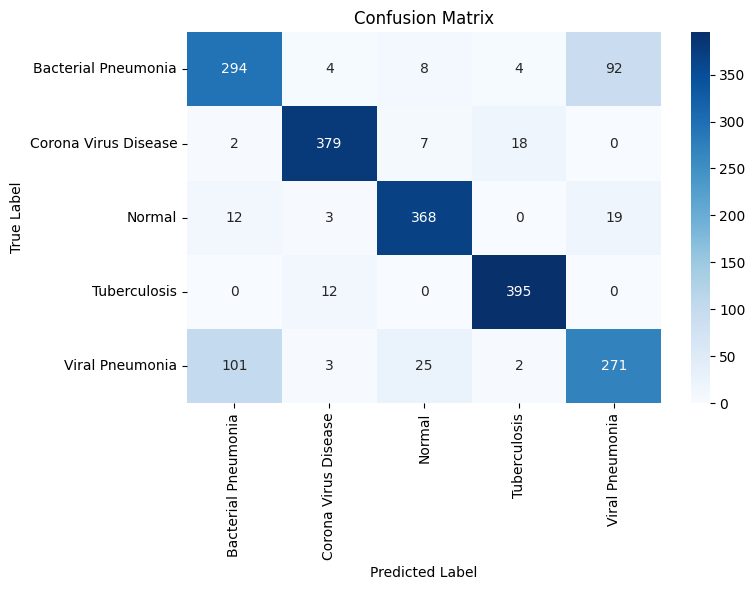

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class names from your label encoder or unique labels
class_names = svm.classes_   # already ordered correctly

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# PREDICTION

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fix_orientation(img):
    """
    Auto-rotate X-ray images to correct portrait orientation using:
    - aspect ratio
    - gradients (horizontal vs vertical edges)
    - 'R' marker detection
    """

    h, w = img.shape

    # 1. If width > height → likely sideways
    if w > h:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    # 2. Use Sobel gradients (horizontal edges mean sideways)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)

    if np.abs(sobelx).mean() > np.abs(sobely).mean() * 1.5:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    # 3. Try detecting “R” marker at top-right
    def has_marker(image):
        H, W = image.shape
        region = image[0:int(H*0.25), int(W*0.65):W]
        return np.mean(region > 220) > 0.003

    if has_marker(img):
        return img

    rot90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if has_marker(rot90):
        return rot90

    rot270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if has_marker(rot270):
        return rot270

    return img


def load_clean_for_display(path, target_size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.zeros((target_size, target_size), dtype=np.uint8)

    # Fix orientation
    img = fix_orientation(img)

    h, w = img.shape
    size = max(h, w)

    # Pad to square
    pad_top = (size - h) // 2
    pad_bottom = size - h - pad_top
    pad_left = (size - w) // 2
    pad_right = size - w - pad_left

    img_padded = cv2.copyMakeBorder(
        img, pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=0
    )

    return cv2.resize(img_padded, (target_size, target_size))


In [ ]:
import os

all_image_paths = []
all_labels = []

splits = ["train", "test", "val"]  # adjust if your dataset uses different names

for split in splits:
    split_dir = os.path.join(data_root, split)
    if not os.path.isdir(split_dir):
        continue

    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for fname in os.listdir(class_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                all_image_paths.append(os.path.join(class_dir, fname))
                all_labels.append(class_name)

print("Total images found:", len(all_image_paths))
print("Classes:", set(all_labels))


Total images found: 10095
Classes: {'Tuberculosis', 'Normal', 'Corona Virus Disease', 'Viral Pneumonia', 'Bacterial Pneumonia'}


In [ ]:
def is_strict_clean_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return False

    h, w, _ = img.shape

    # aspect ratio too extreme → junk
    ratio = w / h
    if ratio < 0.6 or ratio > 1.8:
        return False

    # resolution too tiny → junk
    if h < 300 or w < 300:
        return False

    # remove white or black padded images
    white_ratio = np.mean(img > 240)
    black_ratio = np.mean(img < 15)

    if white_ratio > 0.2 or black_ratio > 0.2:
        return False

    return True


# Build filtered clean dataset
strict_clean_paths = []
strict_clean_labels = []

for p, l in zip(all_image_paths, all_labels):
    if is_strict_clean_image(p):
        strict_clean_paths.append(p)
        strict_clean_labels.append(l)

print("Total strict clean images:", len(strict_clean_paths))

# Build clean reference examples
strict_examples = {}
for p, l in zip(strict_clean_paths, strict_clean_labels):
    if l not in strict_examples:
        strict_examples[l] = p


Total strict clean images: 7803


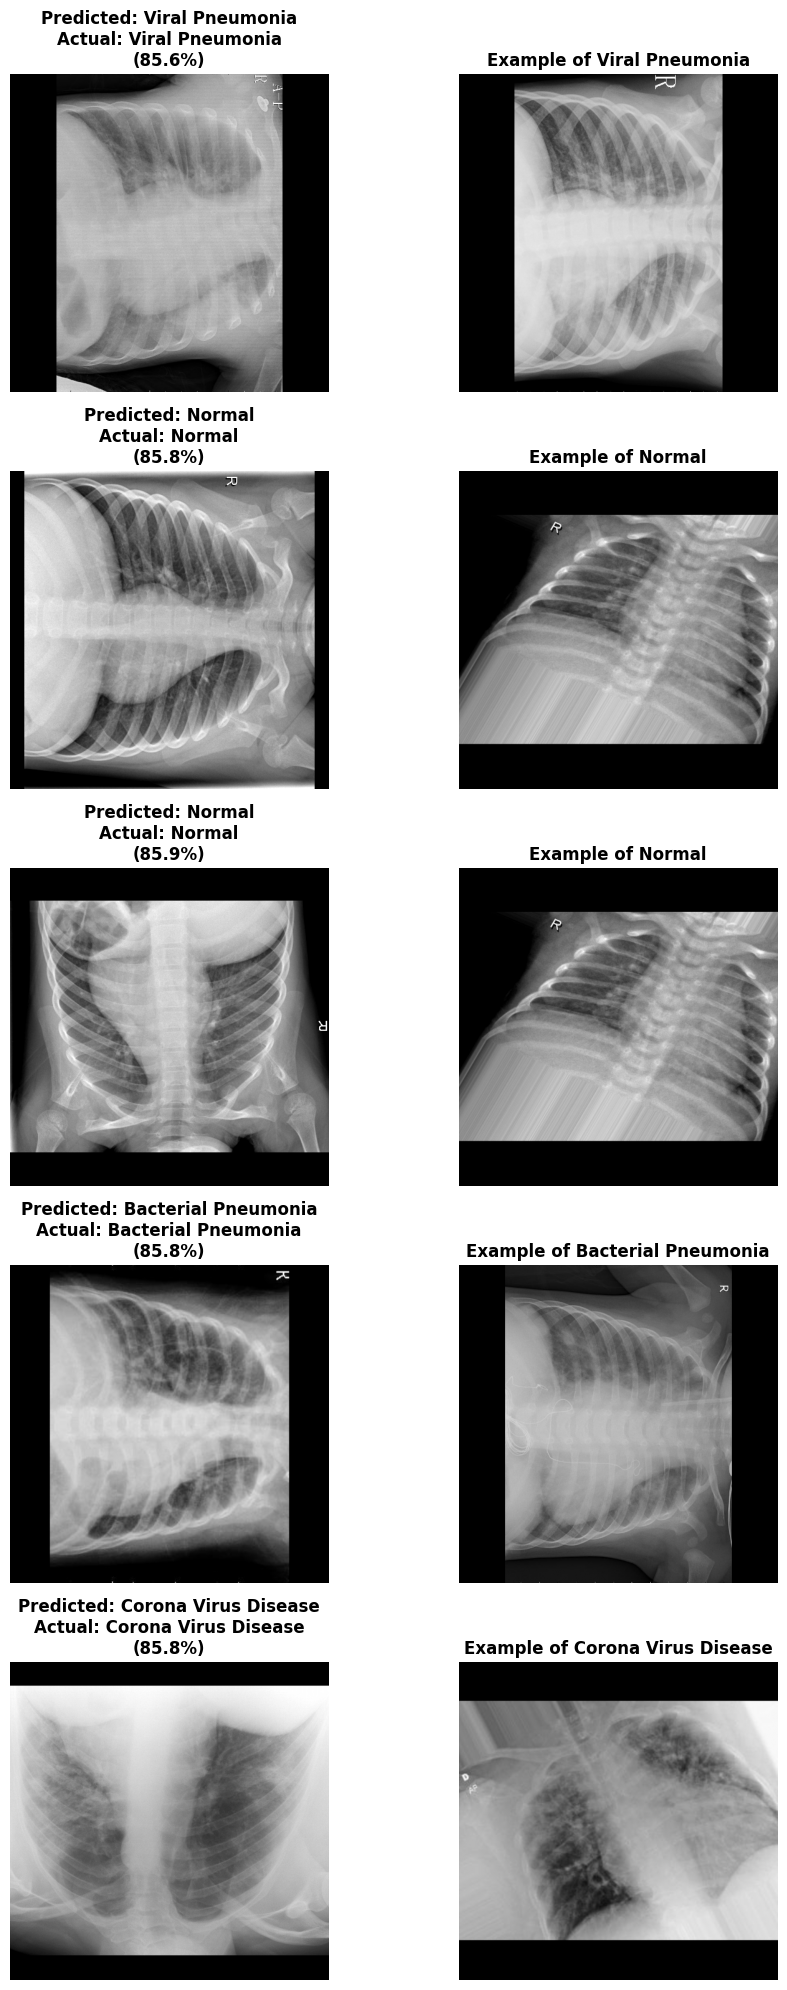

In [ ]:
import random

def predict_with_confidence(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    hog_feat = extract_hog(img)
    lbp_feat = extract_lbp(img)
    combined = np.hstack([hog_feat, lbp_feat])
    combined_scaled = scaler.transform([combined])

    pred = svm.predict(combined_scaled)[0]
    decision_scores = svm.decision_function(combined_scaled)[0]

    if decision_scores.ndim == 0:
        conf = abs(decision_scores)
    else:
        idx = list(svm.classes_).index(pred)
        conf = decision_scores[idx]

    conf_pct = float(conf) * 20
    conf_pct = np.clip(conf_pct, 0, 100)

    return pred, conf_pct


# ---- Visualization ----

num_samples = 5
idxs = random.sample(range(len(strict_clean_paths)), num_samples)

plt.figure(figsize=(10, num_samples * 4))

for i, idx in enumerate(idxs):
    img_path = strict_clean_paths[idx]
    actual_label = strict_clean_labels[idx]

    # Load display images upright + padded
    pred_img = load_clean_for_display(img_path)

    predicted_label, conf_pct = predict_with_confidence(img_path)
    example_img = load_clean_for_display(strict_examples[predicted_label])

    # LEFT = predicted
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(pred_img, cmap="gray")
    plt.title(
        f"Predicted: {predicted_label}\n"
        f"Actual: {actual_label}\n"
        f"({conf_pct:.1f}%)",
        fontsize=12,
        fontweight="bold"
      )
    plt.axis("off")

    # RIGHT = example
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(example_img, cmap="gray")
    plt.title(
        f"Example of {predicted_label}",
        fontsize=12,
        fontweight="bold"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()
